In [1]:
# Goal : Figure out what is the worst possible outcome for this strategy i.e. maximum downside. 

In [24]:
import pandas as pd
import numpy as np
import os
import os.path as osp
from tqdm.notebook import tqdm
import sys
sys.path.append('../../../scripts')
import preprocessing.preprocessing as preprocessing
import matplotlib.pyplot as plt
from datetime import timedelta

In [15]:
# strategy - buy at the close of a particular weekday, sell over the weekend as soon as you make 
# more than the threshold return


def buy_at_weekday_check_weekend(df: pd.DataFrame,
                                 day_of_week: int,
                                 threshold: float):
    """
    df - daily price dataframe,
    day_of_week - int code of day of the week has to be between 0 and 4 (incl)
    threshold - float value which represents the minimum value over which we will sell
    """
    
    tmp = df[df['day_of_week'] == day_of_week]
    tmp = preprocessing.resample(tmp,'1W')

    df_1d_weekends = isolate_weekends(df)
    
    t = list(set(df_1d_weekends.index).intersection(set(tmp.index)))
    t.sort()
    
    df_1d_weekends = df_1d_weekends.loc[t]
    tmp = tmp.loc[t]
    
    diff  =  (df_1d_weekends['high'].values - tmp['close'].values)/(tmp['close'].values)
    
    success_rate = (diff > threshold).sum()/len(diff)
    
    return success_rate,diff

In [200]:
def analyse_slice(df: pd.DataFrame,
                  id1:pd.Timestamp,
                  buy_price: float,
                  threshold: float,
                  epsilon: float,
                  stop_loss: float):

    tmp  = df[id1 + pd.Timedelta('1m') : id1 + pd.Timedelta('2D')]
    
    for index,x in tmp.iterrows():
        if x.close > buy_price + ((threshold + epsilon)* buy_price):
            profit = (x.close - buy_price)/(buy_price)
            return {"success" : True, "timestamp" : index, "profit" : profit}
        elif x.close < buy_price - (stop_loss * buy_price):
            profit = (x.close - buy_price)/buy_price
            return {"success" : False, "timestamp" : index, "profit" : profit}              
        
    return {"success" : False, "timestamp" : index,"profit" : (tmp.low.min() - buy_price)/(buy_price)}        
         
    
    

def find_downside(df: pd.DataFrame,
                  threshold: float,
                  epsilon: float,
                  stop_loss: float
                 ):
    
    df['day_of_week'] = df.index.dayofweek
    tmp = df[df['day_of_week'] == 4]
    tmp1 = tmp[(tmp.index.hour == 23) & (tmp.index.minute == 59)]
    
    answers = []
    
    for id1 in tqdm(tmp1.index):
        buy_price = tmp1.loc[id1]['close']
        ans = analyse_slice(df,id1,buy_price,threshold,epsilon,stop_loss)
        answers.append(ans)
    
    return answers
     
    

In [201]:
df_btc = preprocessing.load_df('../../../data/data_new/raw/Binance/BTC_USDT/BTC_USDT.csv')

df_eth = preprocessing.load_df('../../../data/data_new/raw/Binance/ETH_USDT/ETH_USDT.csv')

Total NaN : 

timestamp    0
open         0
high         0
low          0
close        0
volume       0
returns      1
dtype: int64

Total NaN : 

timestamp    0
open         0
high         0
low          0
close        0
volume       0
returns      1
dtype: int64



In [212]:
ld = df_btc.index[-1] - pd.Timedelta('90D')

In [221]:
threshold = 0.01
epsilon = 0.003
stop_loss = 0.02

results = find_downside(df_eth.loc[ld:],threshold,epsilon,stop_loss)

/tmp/ipykernel_4291/2455008994.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df.index.dayofweek


  0%|          | 0/13 [00:00<?, ?it/s]

In [222]:
#results

In [223]:
np.array([x['success'] for x in results]).sum()/len(results)

0.5384615384615384

In [224]:
losses = []

for x in results:
    if x['success'] == False:
        losses.append(x['profit'])

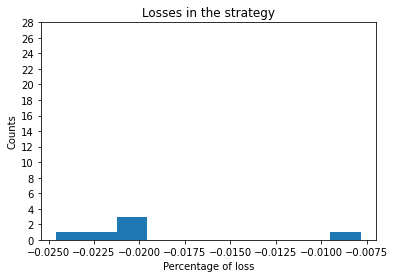

In [225]:
plt.hist(losses)
plt.yticks(np.arange(0,30,2.0))
plt.title('Losses in the strategy')
plt.xlabel('Percentage of loss')
plt.ylabel('Counts')
plt.show()

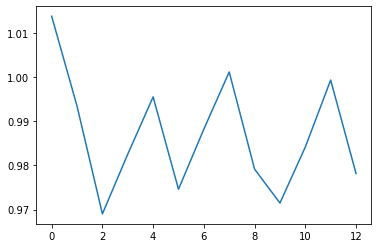

In [226]:
returns = [x['profit'] for x in results]
e = (1 + np.array(returns)).cumprod()

plt.plot(e)

In [218]:
results_losses = [x for x in results if x['success'] == False]
results_losses = sorted(results_losses, key = lambda x : x['profit'], reverse = False)

In [219]:
z  = results_losses[0]
idx = z['timestamp']

<AxesSubplot:xlabel='date'>

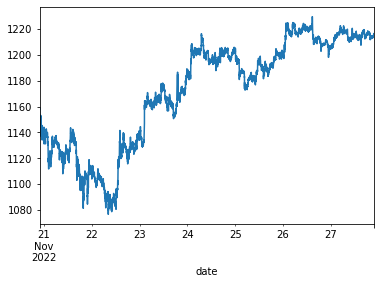

In [220]:
df_eth.loc[idx : idx + pd.Timedelta('7D')].close.plot()

<AxesSubplot:xlabel='date'>

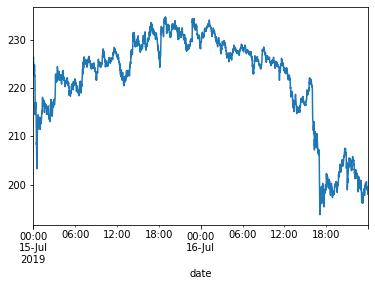

In [182]:
df_eth.loc[idx : idx + pd.Timedelta('2D')].close.plot()